<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0/blob/master/05_CodingDrill/CodingDrill_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code 05

## 1. Target

- Fine Tune the Transforms, set rotation to `-10deg to 10deg`
- Use the OneCycleLR Scheduler since the PyTorch Documentation says
The 1cycle learning rate policy changes the learning rate after every batch. step should be called after a batch has been used for training.

## 2. Result

- Params: `9,962`
## With 
- Best Train Accuracy: `98.11%`
- Best Test Accuracy : `99.33%`

## 3. Analysis

- Now the learning is consistent, the accuracy increases

#### Summarised details for the model coded

- `Conv2D (input_channels), (output_channels), (kernel_size); Out: (output_dim)`
- `MaxPool2D: (kernel_size); Out: (output_dim)`
- `AvgPool2D: (kernel_size); Out: (output_dim)`

- Convolution Block 1
    - `Conv2D:  1, 14, 3; Out: 26x26x14`
    - `Conv2D: 14, 30, 3; Out: 24x24x30`

- Transition Block
    - `Conv2D: 30, 10, 1; Out: 24x24x10`
    - `MaxPool2D: 2x2;    Out: 12x12x10`

- Convolution Block 2
    - `Conv2D: 10, 14, 3; Out: 10x10x14`
    - `Conv2D: 14, 15, 3; Out: 8x8x15`
    - `Conv2D: 15, 15, 3; Out: 6x6x15`

- GAP
    - `AvgPool2D: 6x6;    Out: 1x1x15`
    - `Conv2D: 15, 15, 1; Out: 1x1x15`
    - `Conv2D: 15, 10, 1; Out: 1x1x10`

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# note about pin_memory
# If you load your samples in the Dataset on CPU and would like to push it
# during training to the GPU, you can speed up the host to device transfer by
# enabling pin_memory. This lets your DataLoader allocate the samples in
# page-locked memory, which speeds-up the transfer.

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
              ReLU-6           [-1, 30, 24, 24]               0
       BatchNorm2d-7           [-1, 30, 24, 24]              60
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Introduce tqdm progressbar to get good logs.

Let's write train and test functions

In [7]:
# this automatically selects tqdm for colab_notebook
from tqdm.auto import tqdm, trange

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader, ncols="80%")
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do 
    # backpropragation because PyTorch accumulates the gradients on subsequent 
    # backward passes. 
    # Because of this, when you start your training loop, ideally you should 
    # zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Decay the Learning Rate
    scheduler.step()
    
    # get the index of the max log-probability
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # Update pbar-tqdm
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)

EPOCHS = 15

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Commenting below as Train Accuracy: 98.11% &  Test Accuracy : 99.33%
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# using torch.optim is a package implementing various optimization algorithms in the next code
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=15)

for epoch in range(EPOCHS):
    # Print Learning Rate
    print("EPOCH:", epoch+1, 'LR:', scheduler.get_lr())
    # Train the model
    train(model, device, train_loader, optimizer, epoch)
    # Validate the model
    test(model, device, test_loader)

EPOCH: 1 LR: [0.0003999999999999993]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)




Test set: Average loss: 0.5552, Accuracy: 9234/10000 (92.34%)

EPOCH: 2 LR: [0.0015240079703465938]




Test set: Average loss: 0.0944, Accuracy: 9791/10000 (97.91%)

EPOCH: 3 LR: [0.004369617749135262]




Test set: Average loss: 0.0573, Accuracy: 9846/10000 (98.46%)

EPOCH: 4 LR: [0.0076041259730932256]




Test set: Average loss: 0.0441, Accuracy: 9881/10000 (98.81%)

EPOCH: 5 LR: [0.009712693882270338]




Test set: Average loss: 0.0413, Accuracy: 9868/10000 (98.68%)

EPOCH: 6 LR: [0.009943677941594807]




Test set: Average loss: 0.0331, Accuracy: 9905/10000 (99.05%)

EPOCH: 7 LR: [0.009503461424944768]




Test set: Average loss: 0.0326, Accuracy: 9910/10000 (99.10%)

EPOCH: 8 LR: [0.008663094374661208]




Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 9 LR: [0.00749724709105188]




Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)

EPOCH: 10 LR: [0.006109510221502005]




Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 11 LR: [0.004623190276854037]




Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 12 LR: [0.0031703533067975903]




Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 13 LR: [0.0018800902517922089]




Test set: Average loss: 0.0240, Accuracy: 9931/10000 (99.31%)

EPOCH: 14 LR: [0.0008670466465012771]




Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 15 LR: [0.00022123586092353013]




Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)



# Plot the model's learning progress


Text(0.5, 1.0, 'Test Accuracy')

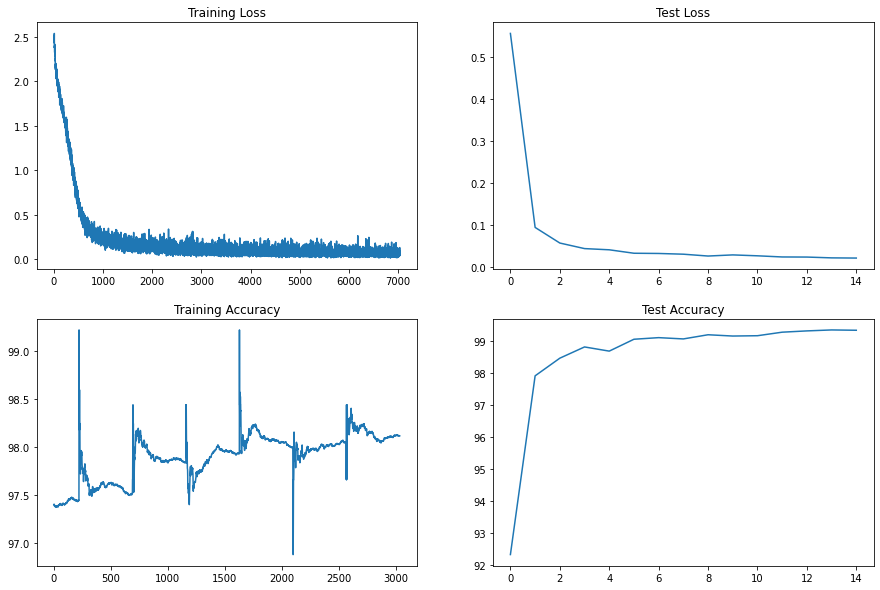

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")